# Machine Learning modeling - World Food Program Disaster Relief -

*@XavierTorres* *@Anel Nurkayeva*

In [106]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import math

In [107]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from warnings import simplefilter

In [108]:
df = pd.read_csv(r'OUTPUT_WBI_exposer.csv')

## Data pre-processing

In [109]:
df.columns

Index(['Unnamed: 0', 'SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN',
       'NATURE', 'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS',
       'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
       'STORM_DR_MEAN', 'V_LAND_KN', '34KN_POP', '34KN_ASSETS', '64KN_POP',
       '64KN_ASSETS', '96KN_POP', '96KN_ASSETS', 'CPI', 'TOTAL_DAMAGE_(000$)',
       'TOTAL_DEATHS', 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'TOTAL_AFFECTED'

In [110]:
# Arranging columns

df = df[[
    # cols from cyclones
    'SID', 'NAME', 'ISO', 'YEAR',  'ISO_TIME', 'COORDS','BASIN', 'SUB BASIN', 'NATURE',
       'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS', 'CPI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',

    # cols from World Bank Indicators:           
    'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
    
    
    # cols from climada:   
    'pop_max_34', 'pop_max_50', 'pop_max_64', 
    
    # Target 
    'TOTAL_AFFECTED']]

In [111]:
df.head(3)

,SID,NAME,ISO,YEAR,ISO_TIME,COORDS,BASIN,SUB BASIN,NATURE,TOTAL_HRS,...,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34,pop_max_50,pop_max_64,TOTAL_AFFECTED
0,1949163N07145,DELLA,JPN,1949,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...","[[35.67, 130.99], [38.35, 135.07], [38.82, 136...",WP,WP,TS,0,...,67.666098,NaN,258.911917,2.867878,36.728,Low,16278929.0,4378623.5,7.321548e+05,194046
1,1950241N23140,JANE,JPN,1950,"['1950-09-02 18:00:00', '1950-09-03 12:00:00',...","[[31.71, 134.12], [38.48, 137.98], [46.7, 152.8]]",WP,WP,ET,6,...,67.666098,NaN,258.911917,2.867878,36.728,Low,39024004.0,14551006.0,4.093306e+06,642117
2,1951224N12316,CHARLIE,JAM,1951,"['1951-08-17 21:00:00', '1951-08-18 12:00:00']","[[17.34, -75.41], [18.3, -79.4]]",NAm,CS,TS,15,...,64.770000,NaN,152.453647,2.578304,66.231,Low,2753687.5,2606976.5,1.067878e+06,20200


In [112]:
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)

In [113]:
df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)
df["TOTAL_DAMAGE_(000$)_Adjusted"].isna().sum()

334

- Trying to create a calculated column that better represents de relative dimension **of exposed assets**. We have several columns for assets exposed depending of windspeed for 34kn+, 64kn+ and 96kn+. Let's add these columns to create a new column:

In [114]:
df['CALC_assets_emdat'] = df['34KN_ASSETS'] + df['64KN_ASSETS'] + df['96KN_ASSETS']
df = df.drop(['64KN_ASSETS', '96KN_ASSETS','96KN_ASSETS'], axis=1)

 - Extracting **month of cyclone**

In [115]:
df['MONTH'] = df.ISO_TIME.apply(lambda x: x[7:9]).astype(int)

- **Transform 'Income_Level'** categories to ordered integers

In [116]:
#Arnab code
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

- **Arranging columns**

In [117]:
df.shape

(1044, 40)

In [118]:
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'ISO_TIME', 'COORDS', 'BASIN',
       'SUB BASIN', 'NATURE', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_ASSETS', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34', 'pop_max_50', 'pop_max_64', 'TOTAL_AFFECTED',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 'MONTH'],
   

In [119]:
#taking out from model=    'SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'ISO_TIME',
# Arranging columns

df = df[[
    # cols from cyclones
    'BASIN', 'SUB BASIN', 'NATURE', 
    'MONTH','TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 
    

    # cols from World Bank Indicators:           
    'Air transport, freight (million ton-km)', 'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
    'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
    'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
    'Life expectancy at birth, total (years)', 'Mobile cellular subscriptions (per 100 people)',
    'Population density (people per sq. km of land area)', 'Adjusted savings: education expenditure (% of GNI)',
    'Rural population (% of total population)', 'Income_level_Final',
    
    
    # cols from climada:   
    'pop_max_64',
    
    # Target 
    'TOTAL_AFFECTED']]

- **Check SKEWENESS and apply log**

In [120]:
#determine index for continous variables
num_feats = df.dtypes[df.dtypes != 'object'].index

#Calculate skew and sort
skew_feats = df[num_feats].skew().sort_values(ascending = False)
skewness = pd.DataFrame({'Skew': skew_feats})

In [121]:
skewness

,Skew
TOTAL_DAMAGE_(000$)_Adjusted,12.137565
Population density (people per sq. km of land area),10.905369
TOTAL_AFFECTED,7.306815
Arable land (hectares per person),5.385385
pop_max_64,4.424959
CALC_assets_emdat,2.788048
"Air transport, freight (million ton-km)",2.600434
Adjusted savings: education expenditure (% of GNI),2.382291
Net flows from UN agencies US$,2.097577
GDP per capita (constant 2010 US$),1.803974


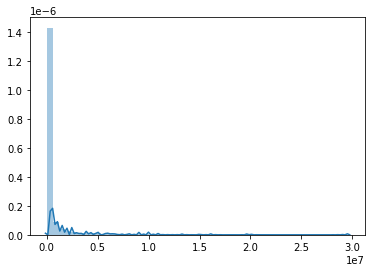

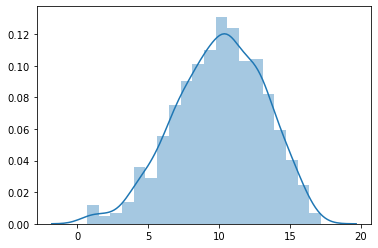

<Figure size 432x288 with 0 Axes>

In [122]:
# Checking distribution for one feature---reusing code from Juber
ax=sns.distplot(df['TOTAL_AFFECTED'].values)

plt.show()
plt.clf()

log_affected=np.log(df['TOTAL_AFFECTED'].values)
ax=sns.distplot(log_affected)

plt.show()
plt.clf()

In [123]:
# Creating list of features to transform, for skew values above 2

feats_to_log = skewness[skewness['Skew'] > 2].index

In [124]:
feats_to_log

Index(['TOTAL_DAMAGE_(000$)_Adjusted',
       'Population density (people per sq. km of land area)', 'TOTAL_AFFECTED',
       'Arable land (hectares per person)', 'pop_max_64', 'CALC_assets_emdat',
       'Air transport, freight (million ton-km)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Net flows from UN agencies US$'],
      dtype='object')

In [125]:
# as log cannot be perfomed to negative numbers, a common technique for handling negative values is to 
# add a constant value to the data prior to applying the log transform. The transformation is 
#therefore log(Y+a) where a is the constant. Some people like to choose a so that min(Y+a) is a very small 
#positive number (like 0.001). Others choose a so that min(Y+a) = 1. For the latter choice, you can show 
# that a = b – min(Y), where b is either a small number or is 1.
# Source : https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html

for item in feats_to_log:
    df[item]=np.log((df[item] + 1 - df[item].min()).values)
    

In [126]:
df[feats_to_log].describe()

,TOTAL_DAMAGE_(000$)_Adjusted,Population density (people per sq. km of land area),TOTAL_AFFECTED,Arable land (hectares per person),pop_max_64,CALC_assets_emdat,"Air transport, freight (million ton-km)",Adjusted savings: education expenditure (% of GNI),Net flows from UN agencies US$
count,7.100000e+02,1044.000000,1044.000000,1043.000000,955.000000,800.000000,877.000000,1.034000e+03,1044.000000
mean,7.078840e+00,4.794178,10.041723,0.147968,12.045252,25.079661,6.142601,1.220461e+00,15.345428
std,2.543001e+00,1.331342,3.146322,0.189803,5.133141,4.153769,2.682769,4.202083e-01,2.548987
min,-1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.110223e-16,0.000000
25%,5.591058e+00,3.895421,8.006034,0.057083,11.678211,23.649528,4.630253,8.333956e-01,13.910457
50%,7.206904e+00,4.968404,10.243081,0.086233,13.728505,25.637095,6.118867,1.185433e+00,16.286149
75%,8.822078e+00,5.691694,12.409058,0.176544,15.105565,27.480435,8.531057,1.560333e+00,17.270565
max,1.430800e+01,9.927154,17.204028,1.403384,18.469617,30.327386,10.668637,2.672155e+00,19.029468


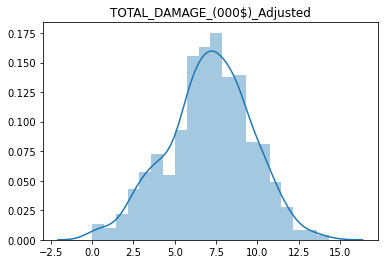

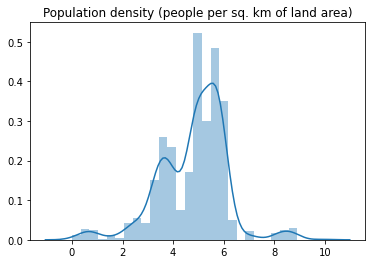

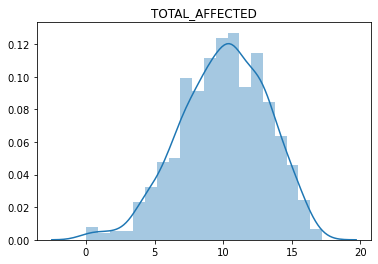

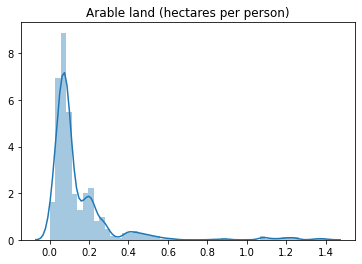

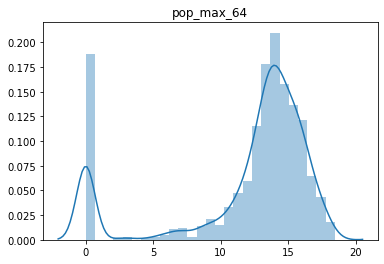

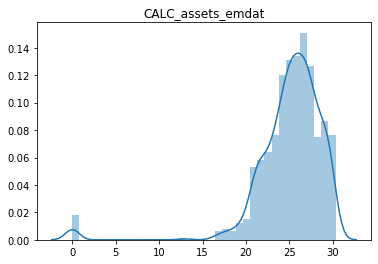

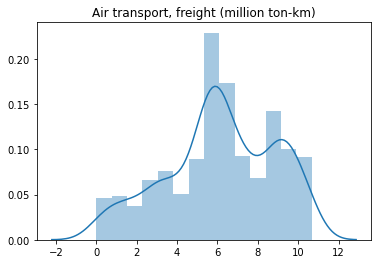

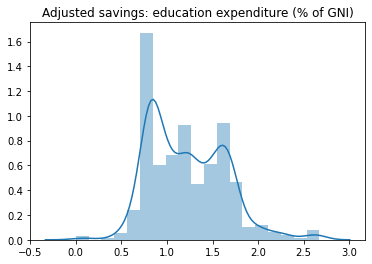

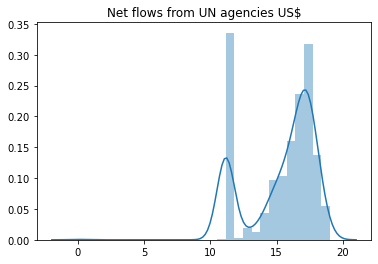

<Figure size 432x288 with 0 Axes>

In [127]:
for item in feats_to_log:
    ax=sns.distplot(df[item].values)
    ax.set_title(item);
    plt.show()
    plt.clf()


In [128]:
df.describe()

,MONTH,TOTAL_HRS,DAY_HRS,NIGHT_HRS,USA_SSHS,WIND_CALC_MEAN,PRES_CALC_MEAN,STORM_SPD_MEAN,STORM_DR_MEAN,V_LAND_KN,...,GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_64,TOTAL_AFFECTED
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1040.000000,1044.000000,1044.000000,1044.000000,1044.000000,...,1035.000000,1044.000000,1040.000000,1035.000000,1044.000000,1.034000e+03,1044.000000,1044.000000,955.000000,1044.000000
mean,7.818008,13.208812,2.137931,11.070881,0.387931,59.914070,975.492309,12.049162,216.493125,90.180173,...,10216.929924,15.345428,70.729056,43.633003,4.794178,1.220461e+00,46.860788,2.512452,12.045252,10.041723
std,2.731062,7.409439,3.845299,8.242185,1.754842,25.249842,55.921213,6.571571,95.485322,31.543540,...,15192.245433,2.548987,7.194427,47.453338,1.331342,4.202083e-01,21.914264,0.961801,5.133141,3.146322
min,1.000000,0.000000,0.000000,-1.000000,-5.000000,18.620690,0.000000,1.565217,2.000000,30.000000,...,168.663976,0.000000,41.762000,0.000000,0.000000,-1.110223e-16,0.000000,1.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,3.000000,-1.000000,40.020833,966.333333,7.635606,155.468182,62.700000,...,1474.179150,13.910457,67.529750,0.062671,3.895421,8.333956e-01,23.954250,2.000000,11.678211,8.006034
50%,8.000000,15.000000,0.000000,9.000000,0.000000,55.276515,981.849624,10.666667,260.803571,89.550000,...,2783.542056,16.286149,71.293000,29.562142,4.968404,1.185433e+00,53.461000,2.000000,13.728505,10.243081
75%,10.000000,21.000000,3.000000,21.000000,1.000000,75.800893,993.600000,14.456294,288.333333,114.750000,...,9125.843396,17.270565,75.177500,84.295542,5.691694,1.560333e+00,64.807000,3.000000,15.105565,12.409058
max,12.000000,23.000000,12.000000,23.000000,5.000000,150.000000,1013.000000,49.800000,358.000000,171.800000,...,86150.462210,19.029468,84.680488,328.790446,9.927154,2.672155e+00,92.421000,4.000000,18.469617,17.204028


- **Apply min_max_scaler**

In [129]:
#df.dropna(inplace = True)

In [130]:
df.shape

(1044, 30)

In [131]:
# first we split df into categorical and numerical features, to merge later
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')


In [132]:
min_max_scaler = preprocessing.MinMaxScaler()

In [133]:
cols_num = df_num.columns #we'll use this later
cols_num

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_64', 'TOTAL_AFFECTED'],
      dtype='object')

In [134]:
# x_cols = [x for x in df.columns if x != 'TOTAL_AFFECTED']

In [135]:
X = df_num.values
x_scaled = min_max_scaler.fit_transform(X)
df_num = pd.DataFrame(x_scaled)

In [136]:
df_num.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.454545,0.000000,0.000000,0.041667,0.5,0.156133,0.987496,0.361457,0.251248,0.492384,...,0.098149,0.586263,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.731133,0.707732
1,0.727273,0.260870,0.000000,0.291667,0.4,0.439790,0.962323,0.444384,0.100187,0.492384,...,0.098149,0.586263,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.824319,0.777290
2,0.636364,0.652174,0.000000,0.666667,0.6,0.531890,0.961994,0.288895,0.790730,0.722144,...,0.042190,0.586263,0.536086,NaN,0.505854,0.416019,0.716623,0.000000,0.751569,0.576225
3,1.000000,0.652174,0.000000,0.666667,0.7,0.501354,0.966978,0.029746,0.448447,0.629055,...,0.010360,0.586263,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.778334,0.639506
4,0.545455,0.130435,0.166667,0.083333,0.6,0.497029,0.968016,0.191455,0.812921,0.569048,...,0.010360,0.586263,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.829088,0.268831


In [137]:
df_num.rename(columns = dict(zip(df_num.columns, cols_num)), inplace = True)

In [138]:
df_num.head(5)

,MONTH,TOTAL_HRS,DAY_HRS,NIGHT_HRS,USA_SSHS,WIND_CALC_MEAN,PRES_CALC_MEAN,STORM_SPD_MEAN,STORM_DR_MEAN,V_LAND_KN,...,GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_64,TOTAL_AFFECTED
0,0.454545,0.000000,0.000000,0.041667,0.5,0.156133,0.987496,0.361457,0.251248,0.492384,...,0.098149,0.586263,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.731133,0.707732
1,0.727273,0.260870,0.000000,0.291667,0.4,0.439790,0.962323,0.444384,0.100187,0.492384,...,0.098149,0.586263,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.824319,0.777290
2,0.636364,0.652174,0.000000,0.666667,0.6,0.531890,0.961994,0.288895,0.790730,0.722144,...,0.042190,0.586263,0.536086,NaN,0.505854,0.416019,0.716623,0.000000,0.751569,0.576225
3,1.000000,0.652174,0.000000,0.666667,0.7,0.501354,0.966978,0.029746,0.448447,0.629055,...,0.010360,0.586263,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.778334,0.639506
4,0.545455,0.130435,0.166667,0.083333,0.6,0.497029,0.968016,0.191455,0.812921,0.569048,...,0.010360,0.586263,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.829088,0.268831


In [139]:
df_num.shape

(1044, 27)

In [140]:
df_cat.shape

(1044, 3)

Merging again df_num and df_cat

In [141]:
df_scaled = pd.merge(df_cat, df_num, how='inner', left_index=True, right_index=True)

In [142]:
df_scaled.head(20)

,BASIN,SUB BASIN,NATURE,MONTH,TOTAL_HRS,DAY_HRS,NIGHT_HRS,USA_SSHS,WIND_CALC_MEAN,PRES_CALC_MEAN,...,GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_64,TOTAL_AFFECTED
0,WP,WP,TS,0.454545,0.000000,0.000000,0.041667,0.5,0.156133,0.987496,...,0.098149,0.586263,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.731133,0.707732
1,WP,WP,ET,0.727273,0.260870,0.000000,0.291667,0.4,0.439790,0.962323,...,0.098149,0.586263,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.824319,0.777290
2,NAm,CS,TS,0.636364,0.652174,0.000000,0.666667,0.6,0.531890,0.961994,...,0.042190,0.586263,0.536086,NaN,0.505854,0.416019,0.716623,0.000000,0.751569,0.576225
3,WP,WP,TS,1.000000,0.652174,0.000000,0.666667,0.7,0.501354,0.966978,...,0.010360,0.586263,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.778334,0.639506
4,WP,WP,TS,0.545455,0.130435,0.166667,0.083333,0.6,0.497029,0.968016,...,0.010360,0.586263,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.829088,0.268831
5,NAm,CS,TS,0.818182,0.260870,0.000000,0.291667,0.8,0.657480,0.964133,...,0.009590,0.586263,0.000000,NaN,0.499393,0.208475,0.913288,0.333333,0.719946,0.722459
6,NAm,GM,TS,0.727273,0.000000,0.000000,0.041667,0.8,0.545482,0.955860,...,0.043484,0.586263,0.356839,NaN,0.297966,0.464991,0.532855,0.000000,0.769030,0.543134
7,WP,WP,TS,0.727273,0.913043,0.000000,0.916667,0.4,0.494593,0.963886,...,0.037357,0.586263,0.587152,NaN,0.809984,0.351794,0.160137,1.000000,NaN,0.273220
8,WP,WP,TS,0.727273,0.913043,0.000000,0.916667,0.4,0.571132,0.944097,...,0.098149,0.586263,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.759976,0.826607
9,WP,WP,TS,0.454545,0.260870,0.500000,0.041667,0.6,0.446387,0.964243,...,0.037357,0.586263,0.587152,0.0,0.809984,0.351794,0.160137,1.000000,NaN,0.559414


In [143]:
df_scaled.shape

(1044, 30)

- **One hot encoding for categorical variables**

In [144]:
obj_feats = df_scaled.dtypes[df_scaled.dtypes == 'object'].index
obj_feats

Index(['BASIN', 'SUB BASIN', 'NATURE'], dtype='object')

In [145]:
feats_to_dummy = obj_feats #selecting feats to make one-hot encoding

for feature in feats_to_dummy:
    dummy = pd.get_dummies(df_scaled[feature], prefix=feature)
    df_scaled = pd.concat([df_scaled,dummy], axis=1)

In [146]:
# Dropping dummed features
df_scaled = df_scaled.drop(feats_to_dummy, axis=1)

In [147]:
df_scaled.columns

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_64', 'TOTAL_AFFECTED', 'BASIN_EP', 'BASIN_NAm', 'BASIN_NI',
       'BASIN_SI', 'BASIN_SP', 'BASIN_WP', 'SUB BASIN_AS', 'SUB BASIN_BB',
       'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN

In [148]:
df_scaled.shape

(1044, 51)

In [149]:
df_scaled.columns

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_64', 'TOTAL_AFFECTED', 'BASIN_EP', 'BASIN_NAm', 'BASIN_NI',
       'BASIN_SI', 'BASIN_SP', 'BASIN_WP', 'SUB BASIN_AS', 'SUB BASIN_BB',
       'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN

In [150]:
#column arrangement 
df_scaled = df_scaled[[
    
     # here columns from cyclones dataset:

    'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN',  
    
        'BASIN_EP', 'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
    'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS',

         
    # here columns from World Bank Indicators dataset:
 
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
         
    #  here columns from climada:
        'pop_max_64',
         
    # Target   
       'TOTAL_AFFECTED']]

In [151]:
df_scaled.shape

(1044, 47)

In [152]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 47 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   MONTH                                                1044 non-null   float64
 1   TOTAL_HRS                                            1044 non-null   float64
 2   DAY_HRS                                              1044 non-null   float64
 3   NIGHT_HRS                                            1044 non-null   float64
 4   USA_SSHS                                             1044 non-null   float64
 5   WIND_CALC_MEAN                                       1040 non-null   float64
 6   PRES_CALC_MEAN                                       1044 non-null   float64
 7   STORM_SPD_MEAN                                       1044 non-null   float64
 8   STORM_DR_MEAN                                        1044 non-null  

### Feature selection

In [163]:
# choosing the features to include in the model
# We take out 'TOTAL_DEATHS' because this input will not be available at the time of prediction
features1 = [   
     # here columns from cyclones dataset:
    'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN',
    
        'BASIN_EP', 'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       #'NATURE_DS', 
    'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS',

         
    # here columns from World Bank Indicators dataset:
    
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
         
    #  here columns from climada:
        'pop_max_64',
         ]

In [164]:
# features2 

features2 = ['MONTH',
       'TOTAL_HRS', 'DAY_HRS', 'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN',
       'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 'BASIN_EP',
       'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
       'pop_max_64_adj']


In [165]:
# arnab feats

features3 = ['TOTAL_HRS', 'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
             'V_LAND_KN', 'Population density (people per sq. km of land area)',
             'Rural population (% of total population)', 'Income_level_Final', 'pop_max_34_adj', 
             'pop_max_50_adj', 'pop_max_64_adj']

In [166]:
df_scaled = df_scaled[df_scaled['TOTAL_AFFECTED'] >0]

In [167]:
#some checks....
df_scaled['BASIN_NAm'].unique()

array([0, 1], dtype=uint8)

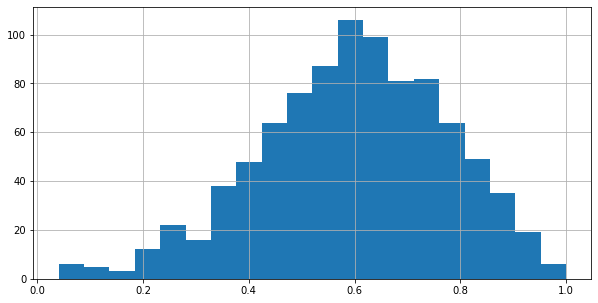

In [168]:
#some checks....
df_scaled['TOTAL_AFFECTED'].hist(bins=20, figsize=(10,5)) #this is logarithmic and scaled(0,1)

__________________

________________________

## Random forest model____________________________________

In [169]:
 df_scaled.dropna(inplace = True)

In [170]:
X = df_scaled[features1].fillna(df_scaled.mean()) #features
# X = df_scaled[features3].fillna(df.mean())
y = df_scaled['TOTAL_AFFECTED']

In [171]:
X.shape

(918, 46)

In [173]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,  0.01,0.001],'kernel': [ 'poly']}

In [175]:
from sklearn.svm import SVR
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)#default = 5fold
grid.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1, kernel=poly .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [190]:
optimised_svr = grid.best_estimator_
poly_results = pd.DataFrame(grid.cv_results_)
poly_results.columns
cols_needed = ['params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score']
poly_results = poly_results[cols_needed]
poly_results.sort_values(by=['rank_test_score'], ascending=True)

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}",0.126740,0.125418,0.123286,0.137135,0.134129,0.129342,0.005338,1
14,"{'C': 100, 'gamma': 0.01, 'kernel': 'poly'}",0.126418,0.125419,0.123318,0.137130,0.134045,0.129266,0.005347,2
10,"{'C': 10, 'gamma': 0.01, 'kernel': 'poly'}",0.106828,0.078504,0.077166,0.085578,0.087998,0.087215,0.010628,3
5,"{'C': 1, 'gamma': 0.1, 'kernel': 'poly'}",0.037288,0.107837,0.142044,0.137163,0.004406,0.085747,0.055255,4
6,"{'C': 1, 'gamma': 0.01, 'kernel': 'poly'}",0.028752,0.002025,0.014708,0.020761,0.015178,0.016285,0.008747,5
2,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}",0.003632,-0.020201,-0.007327,-0.000702,-0.004564,-0.005832,0.008077,6
15,"{'C': 100, 'gamma': 0.001, 'kernel': 'poly'}",0.003632,-0.020201,-0.007327,-0.000702,-0.004564,-0.005832,0.008077,7
11,"{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}",0.000293,-0.022368,-0.010296,-0.003723,-0.007010,-0.008621,0.007718,8
3,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}",-0.000085,-0.021732,-0.010623,-0.004048,-0.007356,-0.008769,0.007364,9
7,"{'C': 1, 'gamma': 0.001, 'kernel': 'poly'}",-0.000050,-0.022523,-0.010593,-0.004018,-0.007325,-0.008902,0.007656,10


In [210]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,  0.01,0.001],'kernel': [ 'sigmoid','rbf']}

from sklearn.svm import SVR
grid = GridSearchCV(SVR(),param_grid,refit=True, scoring='r2', verbose=2)#default = 5fold
grid.fit(X,y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   49.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['sigmoid', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=2)

In [211]:
optimised_svr = grid.best_estimator_
poly_results = pd.DataFrame(grid.cv_results_)



In [212]:
poly_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [213]:
cols_needed = ['params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score']
poly_results = poly_results[cols_needed]
poly_results.sort_values(by=['rank_test_score'], ascending=True)

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
31,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.886352,0.886946,0.876490,0.925981,0.878392,0.890832,0.018062,1
23,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.884511,0.884900,0.877613,0.926314,0.876743,0.890016,0.018461,2
15,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.826945,0.850769,0.845695,0.894722,0.824874,0.848601,0.025188,3
7,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.553839,0.611569,0.601118,0.625760,0.578506,0.594158,0.025380,4
29,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.276637,0.279901,0.300742,0.311349,0.324069,0.298540,0.018154,5
21,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.276637,0.279901,0.300742,0.311349,0.324069,0.298540,0.018154,5
13,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.171077,0.160000,0.179139,0.191403,0.191834,0.178691,0.012181,7
5,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.004663,0.008004,0.012302,0.013575,0.014990,0.010707,0.003820,8
6,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}",-0.000922,0.017952,0.007857,0.002062,0.004633,0.006316,0.006498,9
27,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",-0.001761,-0.000641,-0.000478,-0.000191,-0.000062,-0.000627,0.000603,10


In [196]:
# Applying train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [198]:
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)
print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
print("--------------------------------------------")
y_pred = estimator_RF.predict(X_test)
print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)
print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)
mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)
rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)
cvs = cross_val_score(estimator_RF, X, y).mean()
print("cross_val_score R-squared mean = ", cvs)

NameError: name 'X_pca' is not defined

In [ ]:
##################### Plotting results #########################

df_y = pd.DataFrame(y_test)
df_y['Pred_Total_Affected'] = y_pred
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
# plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('Num_Affected')
plt.title('Num Affected - Test Vs Predictions')
# show a legend on the plot
plt.legend()

# Display  figure
plt.show()

### Hyperparameter tunning with grid search

In [68]:
X = df_scaled[features1].fillna(df_scaled.mean()) #features
# X = df_scaled[features3].fillna(df.mean())
y = df_scaled['TOTAL_AFFECTED']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [70]:
parameters = {'n_estimators':[100, 500, 1000], 
              'max_depth':[5, 10, 20],
              'max_features':[10, 15, 20]              
             }

In [71]:
estimator_RF = GridSearchCV(RandomForestRegressor(), parameters, cv = 3, return_train_score = False)

In [72]:
estimator_RF.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [73]:
GS_results = pd.DataFrame(estimator_RF.cv_results_)
GS_results.columns
cols_needed = ['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score','rank_test_score']
GS_results = GS_results[cols_needed]
GS_results.sort_values(by=['rank_test_score'], ascending=True)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [74]:
cols_needed = ['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score','rank_test_score']
GS_results = GS_results[cols_needed]
GS_results.sort_values(by=['rank_test_score'], ascending=True)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,rank_test_score
25,20,20,500,0.403382,1
26,20,20,1000,0.402402,2
17,10,20,1000,0.397492,3
16,10,20,500,0.396875,4
23,20,15,1000,0.396143,5
15,10,20,100,0.394104,6
14,10,15,1000,0.392962,7
22,20,15,500,0.391628,8
24,20,20,100,0.391140,9
13,10,15,500,0.388022,10


___________________________
________________________________